Debye Streumuster aus einer .dcd Berechnen

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda

from helpers import  better_debye, debye_helper, converters

import pandas as pd

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
H_SCATTERING_LENGTH = -3.7390
O_SCATTERING_LENGTH = 5.803

In [4]:
def load_trajectory(dcd_file: str, pdb_file: str) -> np.ndarray:
    universe = mda.Universe(dcd_file, pdb_file)

    trajectory = []
    for _ in universe.trajectory:
        trajectory.append(universe.atoms.positions)

    return np.array(trajectory)

In [5]:
def calculate_diffraction_patterns(trajectory: np.ndarray) -> np.ndarray:
    _, N_ATOMS, _ = trajectory.shape
    N_MOLECULES = N_ATOMS // 3

    BOX_SIZE = converters.get_box_length_from_density(N_MOLECULES * 3, 0.1)
    
    qs = np.linspace(2.0 * np.pi / BOX_SIZE, 30, 400)

    scattering_lengths = debye_helper.calculate_scattering_length_matrix(
        N_MOLECULES,
        np.array([O_SCATTERING_LENGTH, H_SCATTERING_LENGTH, H_SCATTERING_LENGTH]),
    )

    debye_result = better_debye.get_averaged_debye(trajectory, qs, BOX_SIZE, scattering_lengths)
    averages = np.mean(debye_result, axis=0) / (N_MOLECULES**2)
    return qs, averages

# JAX-MD -> Debye

In [6]:
jaxmd_trajectory = load_trajectory('../data/jaxmd/trajectory.dcd', '../data/jaxmd/trajectory.pdb')
jaxmd_diffraction_x, jaxmd_diffraction_intensity = calculate_diffraction_patterns(jaxmd_trajectory)

df = pd.DataFrame(data={'Q': jaxmd_diffraction_x, 'I_Q': jaxmd_diffraction_intensity})
df.to_csv('../data/diffraction_patterns/jaxmd_then_debye.csv', index=False)

# LAMMPS -> Debye

In [7]:
lammps_trajectory = load_trajectory('../data/lammps/output.dcd', '../data/lammps/trajectory.pdb')
lammps_diffraction_x, lammps_diffraction_intensity = calculate_diffraction_patterns(lammps_trajectory)

df = pd.DataFrame(data={'Q': lammps_diffraction_x, 'I_Q': lammps_diffraction_intensity})
df.to_csv('../data/diffraction_patterns/lammps_then_debye.csv', index=False)

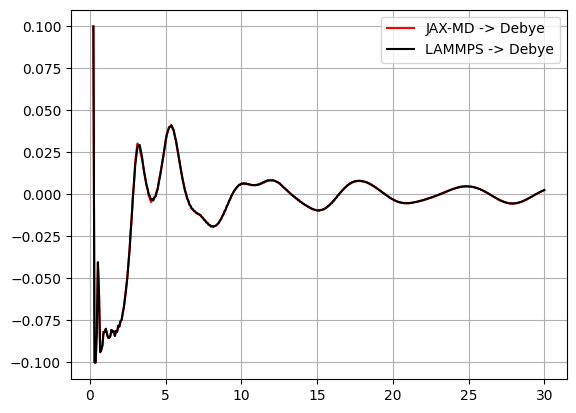

In [12]:
plt.plot(jaxmd_diffraction_x, np.clip(jaxmd_diffraction_intensity, -0.1, 0.1), label='JAX-MD -> Debye', c="red")
plt.plot(lammps_diffraction_x, np.clip(lammps_diffraction_intensity, -0.1, 0.1), label='LAMMPS -> Debye', c="black")
#plt.plot(lammps_diffraction_x, np.clip(lammps_diffraction_intensity, -0.1, 0.1), linestyle="dashed", label='LAMMPS -> Debye', c="black")
plt.legend()
plt.grid()
plt.show()